### Imports

In [281]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../kaggle_prediction_library/') 
import preprocess
import feature_engineering
import submission
from sklearn.model_selection import train_test_split

# from hyperopt import tpe, fmin, Trials
# import hyperopt.hp as hp

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split

import matplotlib.pyplot as plt

from yellowbrick.model_selection import ValidationCurve, LearningCurve



In [282]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.tree import DecisionTreeRegressor


### Data set up

In [283]:
to_predict_mens = pd.read_csv("to_predict_mens.csv")

In [291]:
train = to_predict_mens[to_predict_mens.Season < 2023].copy()

features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank',                
                't1_FGM', 't1_FGA', 't1_FGM3', 't1_FGA3', 't1_OR',
       't1_Ast', 't1_TO', 't1_Stl', 't1_PF', 't1_PointDiff', 't2_FGM',
       't2_FGA', 't2_FGM3', 't2_FGA3', 't2_OR', 't2_Ast', 't2_TO', 't2_Stl',
       't2_PF', 't2_PointDiff', 
       't1_quality', 't2_quality',
       ]

target = 'margin'

train[target] = train[target].astype(int)

train[features] = MinMaxScaler().fit_transform(train[features])



### Param Tuning

In [107]:
def get_best_params_from_grid_search(train, features, target, model, parameters, scoring, verbose=10):
    gs = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, verbose=verbose)
    gs.fit(train[features], train[target])
    return gs.best_params_


In [15]:
model = MLPClassifier(max_iter=1000, random_state=23)

parameters = {'hidden_layer_sizes':[(50,), (100,), (150,)],
              'learning_rate_init':[.0005, .001, .005, .01, .1,],
               'activation':['logistic', 'tanh', 'relu'],
               'alpha':[.0001, .001, .01]
              }

best_params = get_best_params_from_grid_search(train, features, target, model, parameters, 
                                               scoring='neg_brier_score', verbose=15)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 1/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 1/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005;, score=-0.185 total time=   1.1s
[CV 2/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 2/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005;, score=-0.171 total time=   1.2s
[CV 3/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 3/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005;, score=-0.171 total time=   1.3s
[CV 4/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 4/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,

In [14]:
best_params

NameError: name 'best_params' is not defined

### Learning Curve

In [17]:
def plot_learning_curve(train, target, features, model, scoring, xlabel, ylabel, title, yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23):
    viz = LearningCurve(
        model, cv=cv, scoring=scoring, train_sizes=sizes, n_jobs=-1, random_state=random_state)
    viz.fit(train[features], train[target])
    viz.ax.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if yticks:
        viz.ax.set_yticks(yticks)
    plt.show()

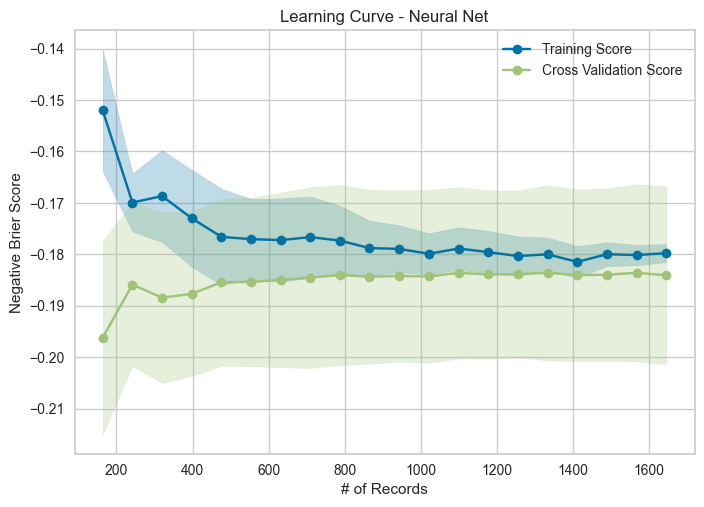

In [18]:
model = MLPClassifier(max_iter=1000, random_state=23, **best_params)

plot_learning_curve(train, 'Outcome', features, model, 
                    'neg_brier_score', 
                    "# of Records", 
                    "Negative Brier Score", 
                    "Learning Curve - Neural Net", 
                    yticks=None, 
                    sizes=np.linspace(0.1, 1.0, 20), 
                    cv=StratifiedKFold(n_splits=10), 
                    random_state=23)


### CV Scoring

In [269]:
# model = MLPRegressor(max_iter=1000, random_state=23, activation='logistic',
#             alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.005)

#model = RandomForestRegressor(max_depth=5)

est = DecisionTreeRegressor(max_depth=5)
model = AdaBoostRegressor(est, n_estimators=100, learning_rate=.001)
preds = np.clip(cross_val_predict(model, train[features], train['margin']), -30, 30)


In [267]:
train[ (train.Season == 2010)
      & (train.Team1 == 1115)]["t1_quality"]

448    -0.853926
1715   -0.853926
Name: t1_quality, dtype: float64

In [258]:
y = train["margin"]

y.describe()

count    2496.000000
mean        0.000000
std        14.411502
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
Name: margin, dtype: float64

In [292]:
import xgboost as xgb
X = train[features].values
dtrain = xgb.DMatrix(X, label = y)

def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)



{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [293]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.37662+0.04420	test-mae:11.38368+0.18653


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:17:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:8.78587+0.02836	test-mae:9.11962+0.09209
[100]	train-mae:8.43007+0.04006	test-mae:9.05391+0.09184
[121]	train-mae:8.32072+0.04597	test-mae:9.06126+0.08882
Fold repeater 1
[0]	train-mae:11.37411+0.04424	test-mae:11.37861+0.19825


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:8.77648+0.03494	test-mae:9.08056+0.19943
[100]	train-mae:8.43778+0.03100	test-mae:9.00304+0.18451
[136]	train-mae:8.25720+0.03085	test-mae:8.99771+0.17896
Fold repeater 2
[0]	train-mae:11.37218+0.05246	test-mae:11.37712+0.22145


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:17:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:8.77830+0.05053	test-mae:9.10095+0.16285
[100]	train-mae:8.43325+0.05029	test-mae:9.02716+0.16325
[130]	train-mae:8.28353+0.05741	test-mae:9.04231+0.16269


In [294]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([96, 112, 105], [9.050867417639148, 8.99607738661594, 9.023472250935452])

In [295]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:17:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:17:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 2


/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:17:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


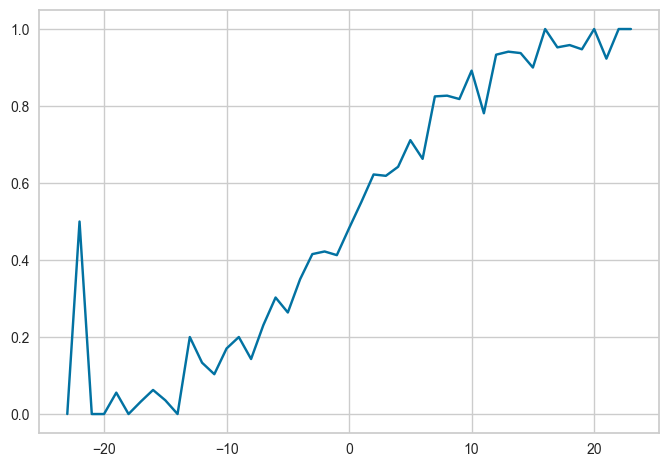

In [296]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [297]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    print(f"logloss of cvsplit {i}: {brier_score_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5565726004282933
logloss of cvsplit 0: 0.19076053660664977
logloss of cvsplit 1: 0.5542221858373386
logloss of cvsplit 1: 0.18972939915669576
logloss of cvsplit 2: 0.5535816068008729
logloss of cvsplit 2: 0.18929149835914114


In [298]:
train.head()

,Unnamed: 0,type,ID,Pred,Season,Team1,Team2,Outcome,Gender,margin,...,t2_adjt_rank,t2_luck,t2_luck_rank,t2_sos_adjem,t2_sos_adjem_rank,t2_sos_opp_o,t2_sos_opp_o_rank,t2_sos_opp_d,t2_sos_opp_d_rank,t2_ncsos_adjem_rank
0,0,Historical,2003_1421_1411,NaN,2003,1421,1411,1.0,M,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Historical,2003_1112_1436,NaN,2003,1112,1436,1.0,M,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Historical,2003_1113_1272,NaN,2003,1113,1272,1.0,M,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Historical,2003_1141_1166,NaN,2003,1141,1166,1.0,M,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Historical,2003_1143_1301,NaN,2003,1143,1301,1.0,M,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank']

In [305]:
train[features]

,seed_diff,t1_adj_margin,t2_adj_margin,t1_final_rank,t2_final_rank,t1_OrdinalRank,t2_OrdinalRank
0,0.500000,-14.910886,-5.397553,66.473193,66.106343,25.0,25.0
1,0.000000,25.784460,5.034632,95.514642,72.542565,1.0,25.0
2,0.600000,19.677837,17.760903,84.559424,86.033588,25.0,25.0
3,0.666667,7.667458,19.827785,82.250901,87.404062,25.0,23.0
4,0.466667,10.033494,13.765783,83.327530,82.508501,25.0,25.0
...,...,...,...,...,...,...,...
2491,0.800000,11.380402,25.104543,80.393360,94.318459,25.0,3.0
2492,0.733333,7.387275,16.644245,73.915248,85.831250,25.0,18.0
2493,0.533333,26.854888,25.104543,90.380569,94.318459,5.0,3.0
2494,0.300000,23.552304,16.644245,89.560373,85.831250,7.0,18.0


In [356]:
from sklearn.model_selection import GridSearchCV
model = GradientBoostingClassifier()


params = {"min_samples_leaf": [2, 10, 50],
          "max_depth": [2, 10, 50],
          "learning_rate": [.001, .01, .1],
          }

X = train[features].values
y = train["Outcome"].values

clf = GridSearchCV(model, params, verbose=10)

clf.fit(X, y)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.001, max_depth=2, min_samples_leaf=2.......


[CV 1/5; 1/27] END learning_rate=0.001, max_depth=2, min_samples_leaf=2;, score=0.698 total time=   1.8s
[CV 2/5; 1/27] START learning_rate=0.001, max_depth=2, min_samples_leaf=2.......
[CV 2/5; 1/27] END learning_rate=0.001, max_depth=2, min_samples_leaf=2;, score=0.735 total time=   1.6s
[CV 3/5; 1/27] START learning_rate=0.001, max_depth=2, min_samples_leaf=2.......
[CV 3/5; 1/27] END learning_rate=0.001, max_depth=2, min_samples_leaf=2;, score=0.671 total time=   1.0s
[CV 4/5; 1/27] START learning_rate=0.001, max_depth=2, min_samples_leaf=2.......
[CV 4/5; 1/27] END learning_rate=0.001, max_depth=2, min_samples_leaf=2;, score=0.687 total time=   1.2s
[CV 5/5; 1/27] START learning_rate=0.001, max_depth=2, min_samples_leaf=2.......
[CV 5/5; 1/27] END learning_rate=0.001, max_depth=2, min_samples_leaf=2;, score=0.663 total time=   0.9s
[CV 1/5; 2/27] START learning_rate=0.001, max_depth=2, min_samples_leaf=10......
[CV 1/5; 2/27] END learning_rate=0.001, max_depth=2, min_samples_leaf=

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 10, 50],
                         'min_samples_leaf': [2, 10, 50]},
             verbose=10)

In [357]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 50}

In [360]:
from sklearn.ensemble import GradientBoostingClassifier


# model = MLPClassifier(max_iter=1500, random_state=23, **{'activation': 'logistic',
#  'alpha': 0.001,
#  'hidden_layer_sizes': (50,),
#  'learning_rate_init': 0.001})

# features = [
#     'seed_diff', 
#             't1_adj_margin', 't2_adj_margin',
#                 't1_final_rank', 't2_final_rank',
#                 't1_OrdinalRank', 't2_OrdinalRank',                
#                 't1_FGM', 't1_FGA', 't1_FGM3', 't1_FGA3', 't1_OR',
#        't1_Ast', 't1_TO', 't1_Stl', 't1_PF', 't1_PointDiff', 't2_FGM',
#        't2_FGA', 't2_FGM3', 't2_FGA3', 't2_OR', 't2_Ast', 't2_TO', 't2_Stl',
#        't2_PF', 't2_PointDiff', 
#     #    't1_quality', 't2_quality',
#        ]

from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(C=.01)

model = GradientBoostingClassifier(**clf.best_params_)

features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 
                't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank',
                      't1_FGM', 't1_FGA', 't1_FGM3', 't1_FGA3', 't1_OR',
       't1_Ast', 't1_TO', 't1_Stl', 't1_PF', 't1_PointDiff', 't2_FGM',
       't2_FGA', 't2_FGM3', 't2_FGA3', 't2_OR', 't2_Ast', 't2_TO', 't2_Stl',
       't2_PF', 't2_PointDiff']

oof_preds_lr = []

X = train[features].values
y = train["Outcome"].values

for i in range(1):
    print(f"Fold repeater {i}")
    preds = y.astype(float).copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X):

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)

        #print(model.predict_proba(X_val)[:, 1])

        preds[val_index] = model.predict_proba(X_val)[:, 1]
        #print(preds)
    print(f"logloss of cvsplit {i}: {log_loss(y,preds)}") 
    print(f"brier score of cvsplit {i}: {brier_score_loss(y,preds)}") 
    oof_preds_lr.append(np.clip(preds,-30,30))


Fold repeater 0
logloss of cvsplit 0: 0.5548448247262681
brier score of cvsplit 0: 0.18933481336282396


In [217]:
from sklearn.model_selection import KFold

oof_preds = []

preds = y.copy()
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)    
for train_index, val_index in kfold.split(X, y):
    dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
    dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
    model = xgb.train(
        params = param,
        dtrain = dtrain_i,
        num_boost_round = 273,
        verbose_eval = 50
    )
    preds[val_index] = model.predict(dval_i)
oof_preds.append(np.clip(preds,-30,30))

/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [237]:
spline_model = []

dat = list(zip(oof_preds[0],np.where(y>0,1,0)))
dat = sorted(dat, key = lambda x: x[0])
datdict = {}
for k in range(len(dat)):
    datdict[dat[k][0]]= dat[k][1]
spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
spline_fit = spline_model[0](oof_preds[0])
spline_fit = np.clip(spline_fit,0.025,0.975)

print(f"adjusted logloss of cvsplit {0}: {log_loss(np.where(y>0,1,0),spline_fit)}") 




adjusted logloss of cvsplit 0: 0.6267717137652911


array([0., 0., 0., ..., 1., 1., 1.])

/var/folders/2g/465yxy_x4g786jx2llr5xqh40000gn/T/ipykernel_16972/1159717814.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = plot_df.groupby('preds')['Outcome', 'prob_preds'].mean().reset_index()


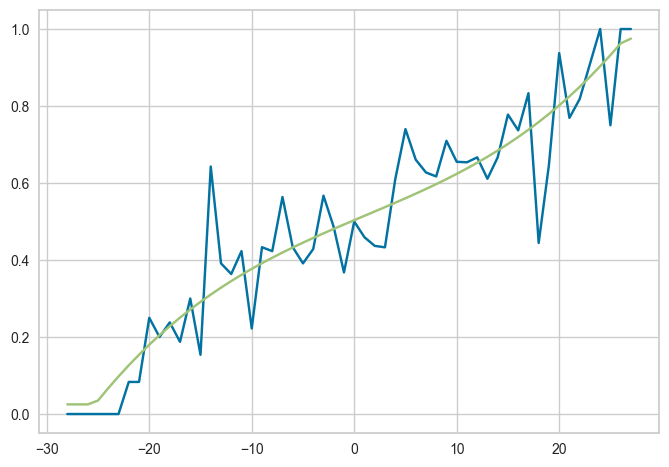

In [218]:
from scipy.interpolate import UnivariateSpline

train["preds"] = preds

train.sort_values(by="preds", inplace=True)

train["prob_preds"] = np.clip(UnivariateSpline(train.preds, train.Outcome)(train.preds),0.025,0.975)

plot_df = train.copy()
plot_df["preds"] = plot_df["preds"].astype(int)

plot_df = plot_df.groupby('preds')['Outcome', 'prob_preds'].mean().reset_index()

plt.figure()
plt.plot(plot_df.preds.astype(int),plot_df.Outcome)
plt.plot(plot_df.preds,plot_df.prob_preds)

In [219]:
brier_score_loss(train.Outcome, train["prob_preds"])


0.23113206994965405

In [204]:
log_loss(train.Outcome, train["prob_preds"])


0.5507448567811783

0.6412869966277142

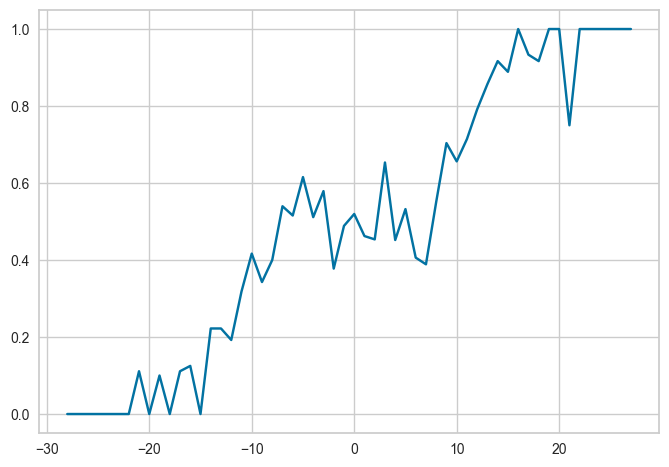

In [37]:
def rolling_season_cv(model, train_input, features, label='margin', cv_start=2007):
    ''' returns estimate for model performance using shifted validation'''
    
    scores = []

    for n, season in enumerate(train_input.Season.unique()):
        
        if season >= cv_start:

            train = train_input[train_input.Season < season]
            test = train_input[train_input.Season == season]

            X_train = train[features]
            X_test = test[features]
            y_train = train[label]
            y_test = test[label]

            model.fit(X_train[features], y_train)
            y_prob = model.predict_proba(X_test[features])
            loss = brier_score_loss(y_test, y_prob[:,1])
            scores.append((season, loss))

    validation_df = pd.DataFrame(scores, columns = ['season', 'score']).sort_values(by = 'score')
    avg_validation_score = validation_df.score.mean()
    return avg_validation_score


In [38]:
# model = MLPClassifier(max_iter=1000, random_state=23, activation='tanh',
#  alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.005)

model = MLPClassifier(max_iter=1000, random_state=23, **best_params)
rolling_season_cv(model, train, features)

0.18334655075070944

In [ ]:
# 0.18339929273381453

In [ ]:
# can try testing out different cv methods
# for each year, build model with 5 seasons from past and 5 from future
# evaluate whether the future model does better (suggesting bias) or if it doesn't matter  

In [14]:
to_predict_mens.Season.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023])

In [ ]:
#2008 - 2017 have 5 seasons on both sides